# 05 - Propensity Score
 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf

from cycler import cycler

color=['0.2', '0.6', '1.0']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

## The Impact of Management Training
 

In [2]:
pd.set_option('display.max_columns', 7)

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/management_training.csv")
df.head()

,departament_id,intervention,engagement_score,...,last_engagement_score,deparament_score,deparament_size
0,76,1,0.277359,...,0.614261,0.224077,843
1,76,1,-0.449646,...,0.069636,0.224077,843
2,76,1,0.769703,...,0.866918,0.224077,843
3,76,1,-0.121763,...,0.029071,0.224077,843
4,76,1,1.526147,...,0.589857,0.224077,843


## Adjusting with Regression
 

In [4]:
import statsmodels.formula.api as smf

smf.ols("engagement_score ~ intervention", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


In [5]:
model = smf.ols("""engagement_score ~ intervention 
+ tenure + last_engagement_score + deparament_score
+ n_of_reports + C(gender) + C(role)""", data=df).fit()

print("ATE:", model.params["intervention"])
print("95% CI:", model.conf_int().loc["intervention", :].values.T)

ATE: 0.2677908576676856
95% CI: [0.23357751 0.30200421]


## Propensity Score
 

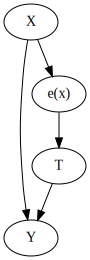

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

### Propensity Score Estimation


In [7]:
ps_model = smf.logit("""intervention ~ 
tenure + last_engagement_score + deparament_score
+ C(n_of_reports) + C(gender) + C(role)""", data=df).fit(disp=0)

In [8]:
data_ps = df.assign(
    propensity_score = ps_model.predict(df),
)

data_ps[["intervention", "engagement_score", "propensity_score"]].head()

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


### Propensity Score and Orthogonalization
 

In [9]:
model = smf.ols("engagement_score ~ intervention + propensity_score",
                data=data_ps).fit()
model.params["intervention"]

0.26331267490277066

### Inverse Propensity Weighting
 

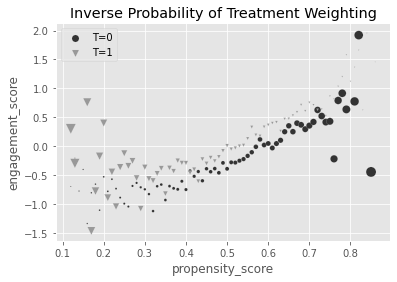

In [10]:
g_data = (data_ps
          .assign(
              weight = data_ps["intervention"]/data_ps["propensity_score"] + (1-data_ps["intervention"])/(1-data_ps["propensity_score"]),
              propensity_score=data_ps["propensity_score"].round(2)
          )
          .groupby(["propensity_score", "intervention"])
#           .agg({"engagement_score":"mean", "weight":sum})
          [["weight", "engagement_score"]]
          .mean()
          .reset_index())

for t in [0, 1]:
    sns.scatterplot(data=g_data.query(f"intervention=={t}"), y="engagement_score", x="propensity_score", size="weight",
                    sizes=(1,100), color=color[t], legend=None, label=f"T={t}", marker=marker[t])

plt.title("Inverse Probability of Treatment Weighting")
plt.legend();

In [11]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])

y1 = sum(data_ps.query("intervention==1")["engagement_score"]*weight_t)/len(data_ps)
y0 = sum(data_ps.query("intervention==0")["engagement_score"]*weight_nt)/len(data_ps)

print("E[Y1]:", y1)
print("E[Y0]:", y0)
print("ATE", y1 - y0)

E[Y1]: 0.11656317232946772
E[Y0]: -0.1494155364781444
ATE 0.2659787088076121


In [12]:
np.mean(data_ps["engagement_score"] 
        * (data_ps["intervention"] - data_ps["propensity_score"]) 
        / (data_ps["propensity_score"]* (1-data_ps["propensity_score"])))

0.26597870880761226

### Variance of IPW
 

In [13]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix

# define function that computes the IPW estimator
def est_ate_with_ps(df, formula, T, Y):
    
    X = dmatrix(formula, df)
    ps_model = LogisticRegression(penalty="none", max_iter=1000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]
    
    # compute the ATE
    return np.mean((df[T]-ps) / (ps*(1-ps)) * df[Y]) 

In [14]:
formula = """tenure + last_engagement_score + deparament_score
+ C(n_of_reports) + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

est_ate_with_ps(df, formula, T, Y)

0.2659755621752663

In [15]:
from joblib import Parallel, delayed # for parallel processing

def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(delayed(est_fn)(data.sample(frac=1, replace=True))
                               for _ in range(rounds))
    
    return np.percentile(stats, pcts)

In [16]:
from toolz import partial

print(f"ATE: {est_ate_with_ps(df, formula, T, Y)}")
print(f"95% C.I.: ", bootstrap(df, partial(est_ate_with_ps, formula=formula, T=T, Y=Y)))

ATE: 0.2659755621752663
95% C.I.:  [0.22654315 0.30072595]


### Stabilized Propensity Weights
 

In [17]:
print("Original Sample Size", data_ps.shape[0])
print("Treated Pseudo-Population Sample Size", sum(weight_t))
print("Untreated Pseudo-Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Pseudo-Population Sample Size 10435.089079197916
Untreated Pseudo-Population Sample Size 10354.298899788304


In [18]:
p_of_t = data_ps["intervention"].mean()

weight_t_stable = p_of_t/data_ps.query("intervention==1")["propensity_score"]
weight_nt_stable = (1-p_of_t)/(1-data_ps.query("intervention==0")["propensity_score"])

print("Treat size:", len(data_ps.query("intervention==1")))
print("W treat", sum(weight_t_stable))

print("Control size:", len(data_ps.query("intervention==0")))
print("W treat", sum(weight_nt_stable))

Treat size: 5611
W treat 5634.807508745978
Control size: 4780
W treat 4763.116999421415


In [19]:
nt = len(data_ps.query("intervention==1"))
nc = len(data_ps.query("intervention==0"))

y1 = sum(data_ps.query("intervention==1")["engagement_score"]*weight_t_stable)/nt
y0 = sum(data_ps.query("intervention==0")["engagement_score"]*weight_nt_stable)/nc

print("ATE: ", y1 - y0)

ATE:  0.26597870880761176


### Pseudo-Populations
 

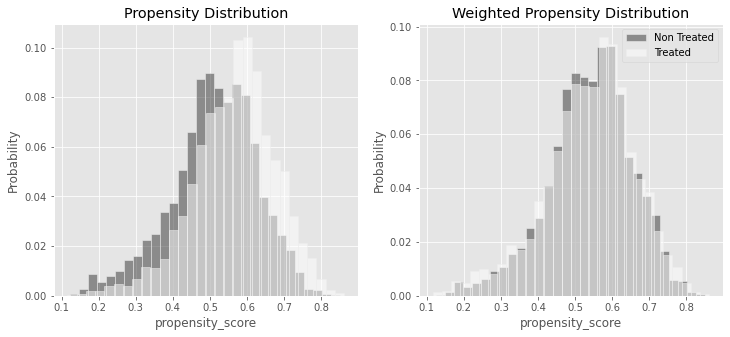

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True)

sns.histplot(data_ps.query("intervention==0")["propensity_score"], stat="probability",
             label="Not Treated", color="C0", bins=30, ax=ax1, alpha=0.5)
sns.histplot(data_ps.query("intervention==1")["propensity_score"], stat="probability",
             label="Treated", color="C2", alpha=0.5, bins=30, ax=ax1)
ax1.set_title("Propensity Distribution")

sns.histplot(data_ps.query("intervention==0").assign(w=weight_nt_stable),
             x="propensity_score", stat="probability",
             color="C0", weights="w", label="Non Treated", bins=30, ax=ax2,  alpha=0.5)

sns.histplot(data_ps.query("intervention==1").assign(w=weight_t_stable),
             x="propensity_score", stat="probability",
             color="C2", weights="w", label="Treated", bins=30, alpha=0.5, ax=ax2)
ax2.set_title("Weighted Propensity Distribution")
plt.legend();

### Selection Bias
 

### Bias-Variance Trade-Off

### Positivity
 

In [21]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.5, n) > 0

y0 = -x
y1 = y0 + t

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

df_no_pos.head()

,x,t,y
0,1.624345,1,-0.526442
1,-0.611756,0,0.659516
2,-0.528172,0,0.438549
3,-1.072969,0,0.950810
4,0.865408,1,-0.271397


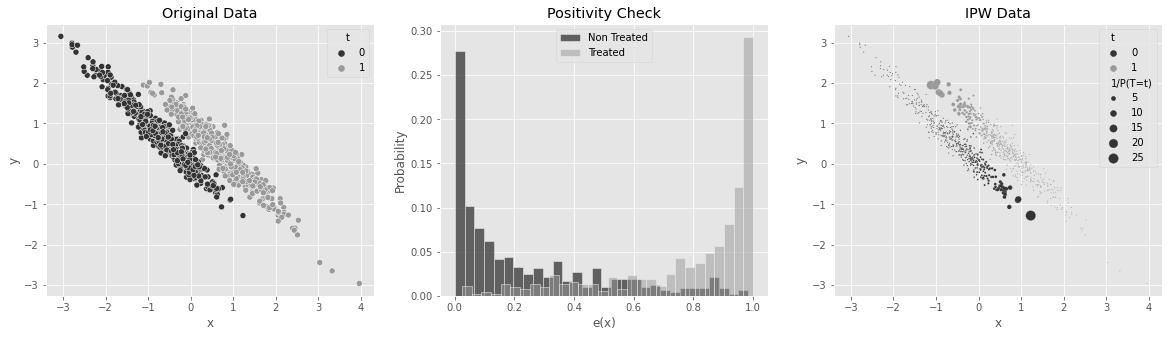

In [22]:
ps_model_sim = smf.logit("""t ~ x""", data=df_no_pos).fit(disp=0)
df_no_pos_ps = df_no_pos.assign(ps=ps_model_sim.predict(df_no_pos))

ps = ps_model_sim.predict(df_no_pos)
w = df_no_pos["t"]*df_no_pos["t"].mean()/ps  + (1-df_no_pos["t"])*((1-df_no_pos["t"].mean())/(1-ps))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

sns.scatterplot(data=df_no_pos_ps.assign(w=w), x="x", y="y", hue="t", ax=ax1);
ax1.set_title("Original Data")

sns.histplot(df_no_pos_ps.query("t==0")["ps"], stat="probability",
             label="Non Treated", color="C0", bins=30, ax=ax2)
sns.histplot(df_no_pos_ps.query("t==1")["ps"], stat="probability",
             label="Treated", color="C1", alpha=0.5, bins=30, ax=ax2)
ax2.set_xlabel("e(x)")
ax2.legend()
ax2.set_title("Positivity Check")


sns.scatterplot(data=df_no_pos_ps.assign(**{"1/P(T=t)":w}), x="x", y="y", hue="t", ax=ax3, size="1/P(T=t)", sizes=(1, 100));
ax3.set_title("IPW Data");

In [23]:
est_fn = partial(est_ate_with_ps, formula="x", T="t", Y="y")
print("ATE:",  est_fn(df_no_pos))
print(f"95% C.I.: ", bootstrap(df_no_pos, est_fn))

ATE: 0.6478011810615735
95% C.I.:  [0.41710504 0.88840195]


In [24]:
smf.ols("t ~ x + t", data=df_no_pos).fit().params["t"]

1.0

## Doubly Robust Estimation
 

In [25]:
from sklearn.linear_model import LinearRegression

def doubly_robust(df, formula, T, Y):
    X = dmatrix(formula, df)
    
    ps_model = LogisticRegression(penalty="none", max_iter=1000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]
    
    m0 = LinearRegression().fit(X[df[T]==0, :], df.query(f"{T}==0")[Y]).predict(X)
    m1 = LinearRegression().fit(X[df[T]==1, :], df.query(f"{T}==1")[Y]).predict(X)

    return (
        np.mean(df[T]*(df[Y] - m1)/ps + m1) -
        np.mean((1-df[T])*(df[Y] - m0)/(1-ps) + m0)
    )

In [26]:
formula = """tenure + last_engagement_score + deparament_score
+ C(n_of_reports) + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

print("DR ATE:", doubly_robust(df, formula, T, Y))
print("95% CI", bootstrap(df, partial(doubly_robust, formula=formula, T=T, Y=Y)))

DR ATE: 0.27115831057931455
95% CI [0.23012681 0.30524944]


### Treatment is Easy to Model
 

In [27]:
np.random.seed(123)

n = 10000
x = np.random.beta(1,1, n).round(2)*2
e = 1/(1+np.exp(-(1+1.5*x)))
t = np.random.binomial(1, e)

y1 = 1
y0 = 1 - 1*x**3
y = t*(y1) + (1-t)*y0 + np.random.normal(0, 1, n)

df_easy_t = pd.DataFrame(dict(y=y, x=x, t=t))

print("True ATE:", np.mean(y1-y0))

True ATE: 2.0056243152


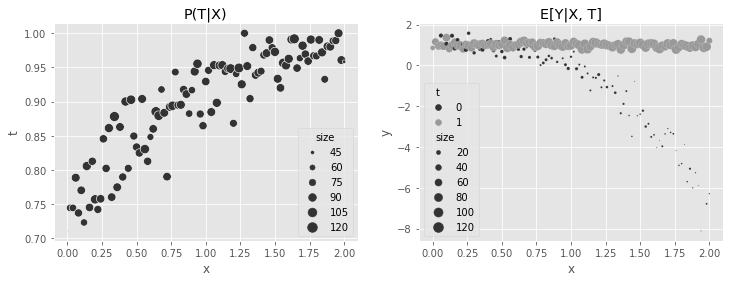

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(data=(df_easy_t
                      .assign(size=1)
                      .groupby(["x"])
                      .agg({"size":"sum", "t":"mean"})
                      .reset_index()),
                x="x", y="t", sizes=(1, 100), size="size", ax=ax1);
ax1.set_title("P(T|X)")

sns.scatterplot(data=(df_easy_t
                      .assign(size=1)
                      .groupby(["x", "t"])
                      .agg({"size":"sum", "y":"mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1, 100), size="size", ax=ax2)

ax2.set_title("E[Y|X, T]");

In [29]:
m0 = smf.ols("y~x", data=df_easy_t.query("t==0")).fit()
m1 = smf.ols("y~x", data=df_easy_t.query("t==1")).fit()
regr_ate = (m1.predict(df_easy_t) - m0.predict(df_easy_t)).mean()

print("Regression ATE:", regr_ate)

Regression ATE: 1.786678396833022


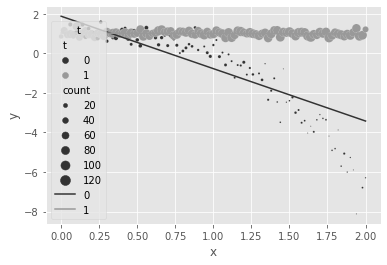

In [30]:
regr = smf.ols("y~x*t", data=df_easy_t).fit()

sns.scatterplot(data=(df_easy_t
                      .assign(count=1)
                      .groupby(["x", "t"])
                      .agg({"count":"sum", "y":"mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1, 100), size="count");

sns.lineplot(data=(df_easy_t
                   .assign(pred=regr.fittedvalues)
                   .groupby(["x", "t"])
                   .mean()
                   .reset_index()),
             x="x", y="pred", hue="t", sizes=(1, 100));

In [31]:
m = smf.ols("y~t*(x + np.power(x, 3))", data=df_easy_t).fit()
regr_ate = (m.predict(df_easy_t.assign(t=1))
            - m.predict(df_easy_t.assign(t=0))).mean()

print("Regression ATE:", regr_ate)

Regression ATE: 1.9970999747190072


In [32]:
est_fn = partial(est_ate_with_ps, formula="x", T="t", Y="y")
print("Propensity Score ATE:", est_fn(df_easy_t))
print("95% CI", bootstrap(df_easy_t, est_fn))

Propensity Score ATE: 2.002350388474011
95% CI [1.80802227 2.22565667]


In [33]:
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print("DR ATE:", est_fn(df_easy_t))
print("95% CI", bootstrap(df_easy_t, est_fn))

DR ATE: 2.001617934263116
95% CI [1.87088771 2.145382  ]


### Outcome is Easy to Model
 

In [34]:
np.random.seed(123)

n = 10000
x = np.random.beta(1,1, n).round(2)*2
e = 1/(1+np.exp(-(2*x - x**3)))
t = np.random.binomial(1, e)

y1 = x
y0 = y1 + 1
y = t*(y1) + (1-t)*y0 + np.random.normal(0, 1, n)

df_easy_y = pd.DataFrame(dict(y=y, x=x, t=t))

print("True ATE:", np.mean(y1-y0))

True ATE: -1.0


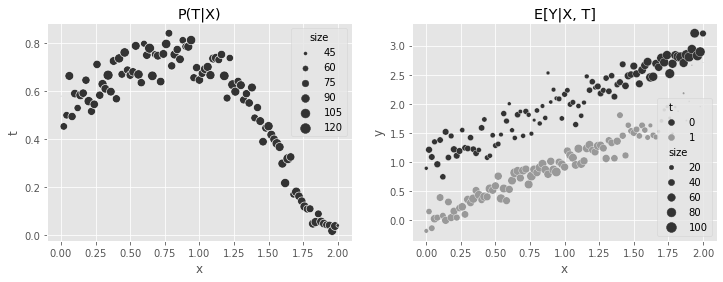

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(data=(df_easy_y
                      .assign(size=1)
                      .groupby(["x"])
                      .agg({"size":"sum", "t":"mean"})
                      .reset_index()),
                x="x", y="t", sizes=(1, 100), size="size", ax=ax1);

sns.scatterplot(data=(df_easy_y
                      .assign(size=1)
                      .groupby(["x", "t"])
                      .agg({"size":"sum", "y":"mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1, 100), size="size", ax=ax2);

ax1.set_title("P(T|X)")
ax2.set_title("E[Y|X, T]");

In [36]:
est_fn = partial(est_ate_with_ps, formula="x", T="t", Y="y")
print("Propensity Score ATE:", est_fn(df_easy_y))
print("95% CI", bootstrap(df_easy_y, est_fn))

Propensity Score ATE: -1.1042900278680896
95% CI [-1.14326893 -1.06576358]


In [37]:
m0 = smf.ols("y~x", data=df_easy_y.query("t==0")).fit()
m1 = smf.ols("y~x", data=df_easy_y.query("t==1")).fit()
regr_ate = (m1.predict(df_easy_y) - m0.predict(df_easy_y)).mean()

print("Regression ATE:", regr_ate)

Regression ATE: -1.0008783612504342


In [38]:
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print("DR ATE:", est_fn(df_easy_y))
print("95% CI", bootstrap(df_easy_y, est_fn))

DR ATE: -1.0028459347805823
95% CI [-1.04156952 -0.96353366]


## Generalized Propensity Score for Continuous Treatment
 

In [39]:
df_cont_t = pd.read_csv("./data/interest_rate.csv")

df_cont_t.head()

,Unnamed: 0,ml_1,ml_2,interest,duration
0,0,0.392938,0.326285,7.1,12.0
1,1,-0.427721,0.679573,5.6,17.0
2,2,-0.546297,0.647309,11.1,12.0
3,3,0.102630,-0.264776,7.2,18.0
4,4,0.438938,-0.648818,9.5,19.0


In [40]:
m_naive = smf.ols("duration ~ interest", data=df_cont_t).fit()
m_naive.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.5033,0.226,64.283,0.000,14.061,14.946
interest,0.3393,0.029,11.697,0.000,0.282,0.396


In [41]:
model_t = smf.ols("interest~ml_1+ml_2", data=df_cont_t).fit()

In [42]:
def conditional_density(x, mean, std):
    denom = std*np.sqrt(2*np.pi)
    num = np.exp(-((1/2)*((x-mean)/std)**2))
    return (num/denom).ravel()
    

gps = conditional_density(df_cont_t["interest"],
                          model_t.fittedvalues,
                          np.std(model_t.resid))
gps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [43]:
from scipy.stats import norm

gps = norm(loc=model_t.fittedvalues,
           scale=np.std(model_t.resid)).pdf(df_cont_t["interest"])
gps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [44]:
final_model = smf.wls("duration ~ interest", data=df_cont_t, weights=1/gps).fit()
final_model.params["interest"]

-0.6673977919925854

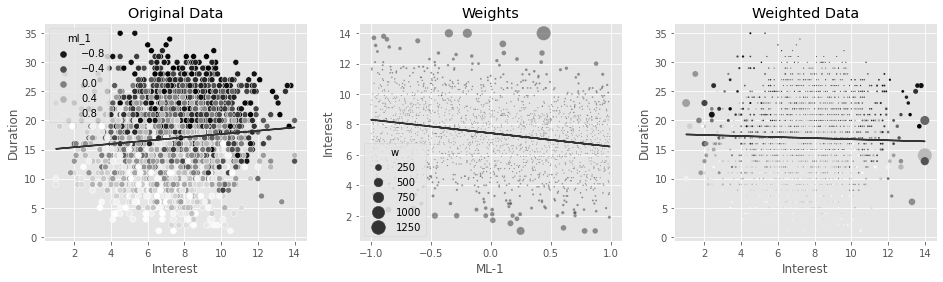

In [45]:
np.random.seed(1)
sample = df_cont_t.sample(2000)



model_ex = smf.ols("interest~ml_1", data=sample).fit()
gps_ex = norm(loc=model_ex.fittedvalues, scale=np.std(model_ex.resid)).pdf(sample["interest"])

w_ex = 1/gps_ex

m = smf.ols("duration~interest", data=sample).fit()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

sns.scatterplot(data=sample, x="interest", y="duration", alpha=1, ax=ax1, hue="ml_1", palette = 'gray')
ax1.plot(sample["interest"], m.fittedvalues)

ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data");


sns.scatterplot(data=sample.assign(w=w_ex), x="ml_1", y="interest",size="w",
                sizes=(1,200), alpha=0.5, ax=ax2)
ax2.plot(sample["ml_1"], model_ex.fittedvalues)
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")


m = smf.wls("duration~interest", data=sample, weights=w_ex).fit()

sns.scatterplot(data=sample.assign(w=w_ex), x="interest", y="duration",size="w",
                sizes=(1,200), alpha=1, ax=ax3, hue="ml_1", legend=None, palette = 'gray')
ax3.plot(sample["interest"], m.fittedvalues)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data");


In [46]:
stabilizer = norm(
    loc=df_cont_t["interest"].mean(),
    scale=np.std(df_cont_t["interest"] - df_cont_t["interest"].mean())
).pdf(df_cont_t["interest"])

gipw =  stabilizer/gps

print("Original Sample Size:", len(df_cont_t))
print("Effective Stable Weights Sample Size:", sum(gipw))

Original Sample Size: 10000
Effective Stable Weights Sample Size: 9988.19595174861


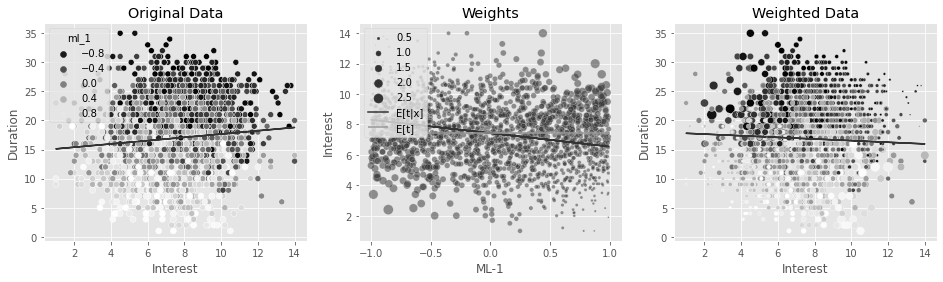

In [47]:
np.random.seed(1)
sample = df_cont_t.sample(2000)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

model_ex = smf.ols("interest~ml_1", data=sample).fit()
gps_ex = norm(loc=model_ex.fittedvalues, scale=np.std(model_ex.resid)).pdf(sample["interest"])
stabilizer_ex = norm(
    loc=sample["interest"].mean(),
    scale=np.std(sample["interest"] - sample["interest"].mean())
).pdf(sample["interest"])


w_ex = stabilizer_ex/gps_ex

m = smf.ols("duration~interest", data=sample).fit()

sns.scatterplot(data=sample, x="interest", y="duration", alpha=1, ax=ax1, hue="ml_1", palette = 'gray')
ax1.plot(sample["interest"], m.fittedvalues)
ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data");


sns.scatterplot(data=sample.assign(w=w_ex), x="ml_1", y="interest",size="w",
                sizes=(1,100), alpha=0.5, ax=ax2)
ax2.plot(sample["ml_1"], model_ex.fittedvalues, label="E[t|x]")
ax2.hlines(sample["interest"].mean(), -1, 1, label="E[t]", color="C1")
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.legend(loc=2)
ax2.set_title("Weights")

m = smf.wls("duration~interest", data=sample, weights=w_ex).fit()

sns.scatterplot(data=sample.assign(w=w_ex), x="interest", y="duration",size="w",
                sizes=(1,100), alpha=1, ax=ax3, hue="ml_1", legend=None, palette = 'gray')
ax3.plot(sample["interest"], m.fittedvalues)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data");

In [48]:
final_model = smf.wls("duration ~ interest", data=df_cont_t, weights=gipw).fit()
final_model.params["interest"]

-0.7787046278134069

In [49]:
def gps_normal_ate(df, formula, T, Y, stable=True):
    mt = smf.ols(f"{T}~"+formula, data=df).fit()
    gps = norm(loc=mt.fittedvalues, scale=np.std(mt.resid)).pdf(df[T])
    stabilizer = norm(
        loc=df[T].mean(),
        scale=np.std(df[T] - df[T].mean())
    ).pdf(df[T])
    
    if stable:
        return smf.wls(f"{Y}~{T}", data=df, weights=stabilizer/gps).fit().params[T]
    else:
        return smf.wls(f"{Y}~{T}", data=df, weights=1/gps).fit().params[T]

print("95% CI, non-stable: ", bootstrap(df_cont_t, partial(gps_normal_ate, formula="ml_1 + ml_2", T="interest", Y="duration", stable=False)))
print("95% CI, stable: ", bootstrap(df_cont_t, partial(gps_normal_ate, formula="ml_1 + ml_2", T="interest", Y="duration")))

95% CI, non-stable:  [-0.81074164 -0.52605933]
95% CI, stable:  [-0.85834311 -0.71001914]


## Keys Ideas
 

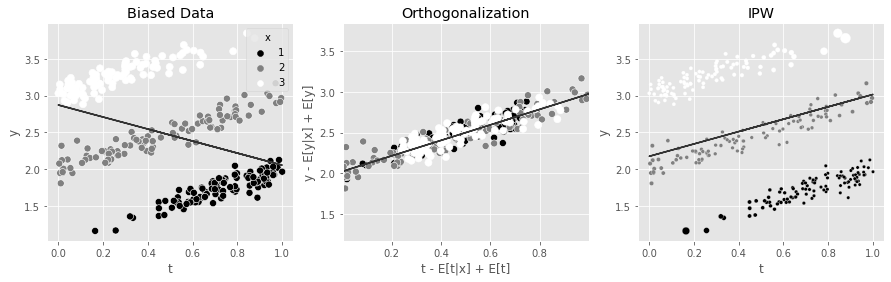

In [50]:
np.random.seed(1)

n=100

df1 = pd.DataFrame(dict(
    x=1,
    t=np.random.beta(2.5,1, n),
)).assign(y = lambda d: np.random.normal(d["x"]+d["t"], 0.1))

df2 = pd.DataFrame(dict(
    x=2,
    t=np.random.beta(1,1, n),
)).assign(y = lambda d: np.random.normal(d["x"]+d["t"], 0.1))

df3 = pd.DataFrame(dict(
    x=3,
    t=np.random.beta(1,2.5, n),
)).assign(y = lambda d: np.random.normal(d["x"]+d["t"], 0.1))


df_example = pd.concat([df1, df2, df3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

m = smf.ols("y~t", data=df_example).fit()
sns.scatterplot(data=df_example, x="t", y="y",  hue="x", s=50, ax=ax1, palette = 'gray')
ax1.plot(df_example["t"], m.fittedvalues)
ax1.set_title("Biased Data")

## Orthogonalization

mt = smf.ols("t~x", data=df_example).fit()
my = smf.ols("y~x", data=df_example).fit()

df_ex_res = df_example.assign(
    t_res = mt.resid + df_example["t"].mean(),
    y_res = my.resid + df_example["y"].mean()
)

m_final = smf.ols("y_res~t_res", data=df_ex_res).fit()
sns.scatterplot(data=df_ex_res, x="t_res", y="y_res",  hue="x", s=50, ax=ax2, legend=None, palette = 'gray')
ax2.plot(df_ex_res["t_res"], m_final.fittedvalues)

ax2.set_ylim(df_example["y"].min(), df_example["y"].max())
ax2.set_xlim(df_example["t"].min(), df_example["t"].max())

ax2.set_ylabel("y - E[y|x] + E[y]")
ax2.set_xlabel("t - E[t|x] + E[t]")
ax2.set_title("Orthogonalization")


## IPW
gps_example = norm(loc=mt.fittedvalues, scale=np.std(mt.resid)).pdf(df_example["t"])
stabilizer_example = norm(
    loc=df_example["t"].mean(),
    scale=np.std(df_example["t"] - df_example["t"].mean())
).pdf(df_example["t"])


w_example = stabilizer_example/gps_example
mw = smf.wls("y~t", data=df_example, weights=w_example).fit()


sns.scatterplot(data=df_example.assign(w=w_example), x="t", y="y",  hue="x", ax=ax3, size="w",
                legend=None, sizes=(11,100), palette = 'gray')
ax3.plot(df_example["t"], mw.fittedvalues)
ax3.set_title("IPW");